In [1]:
# Módulos de Astropy
from astropy.io import fits
from astropy.table import Table

# Módulos de visualización y cálculo numérico
import matplotlib.pyplot as plt
import numpy as np

# Módulos de sklearn para división de datos y búsqueda en grilla
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Módulos de TensorFlow y TensorFlow Addons
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, LeakyReLU
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

# Módulo de itertools para la generación de productos cartesianos
from itertools import product


2023-04-17 14:29:09.316557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 14:29:10.183198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
path_datos = "../data/"
path = path_datos + "ZW2.msw_image.fits"
hdul = fits.open(path)

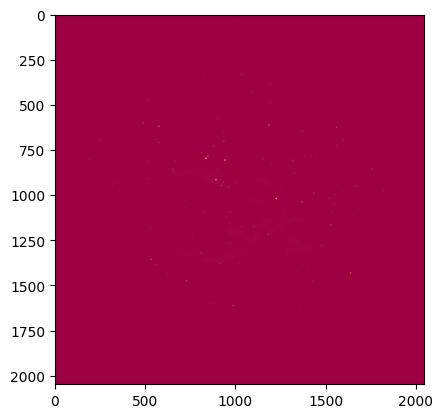

In [3]:
data=hdul[0].data
plt.imshow(data[0], cmap="Spectral")

In [4]:
path_cat = "catalogo.cat"
cat = Table.read(path_cat, format="ascii")

# Crear un archivo de anotación
clase = "fuente"
with open("galaxias_sextractor_marcos.txt", "w") as f:
    for row in cat:
        # Obtener las coordenadas de la galaxia
        x = row["X_IMAGE"]
        y = row["Y_IMAGE"]

        # Escribir la anotación en el archivo
        f.write(f"{x} {y} {clase}\n")

In [5]:
# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor_marcos.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1

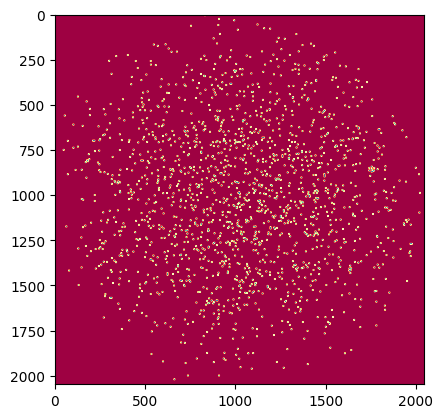

In [6]:
plt.imshow(label, cmap="Spectral")

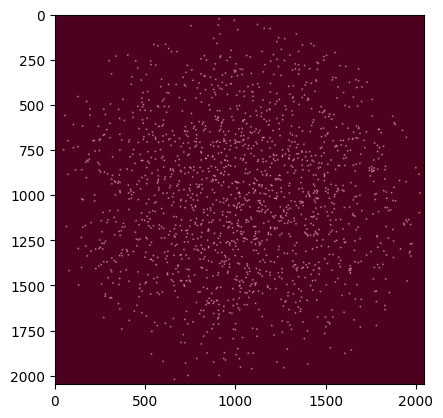

In [7]:
plt.imshow(label, cmap="gray")#label
plt.imshow(data[0], cmap="Spectral",alpha=0.5)#imagen
# Mostrar la imagen combinada
plt.show()

In [11]:
all_data = hdul[0].data

# Seleccionar x frecuencias distintas de manera aleatoria
num_samples = 400
indices = sorted(np.random.choice(all_data.shape[0], num_samples, replace=False))
data = all_data[indices]
print(indices)

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')

save_indices_to_txt(indices, "indices.txt")

[2, 3, 6, 8, 12, 13, 14, 15, 17, 22, 28, 29, 30, 37, 38, 39, 50, 51, 52, 54, 57, 58, 59, 61, 63, 64, 66, 67, 69, 76, 78, 80, 81, 86, 88, 90, 96, 97, 99, 104, 109, 112, 115, 117, 118, 119, 120, 123, 124, 125, 126, 127, 132, 134, 136, 141, 142, 144, 147, 149, 151, 152, 153, 158, 160, 162, 167, 168, 169, 171, 172, 176, 178, 179, 181, 184, 185, 187, 188, 189, 192, 196, 199, 202, 203, 209, 212, 214, 218, 220, 223, 228, 233, 235, 236, 239, 241, 245, 247, 253, 255, 259, 261, 262, 265, 266, 267, 270, 271, 272, 274, 275, 277, 280, 282, 284, 288, 289, 290, 294, 301, 302, 304, 305, 306, 309, 310, 311, 314, 315, 317, 318, 322, 325, 327, 330, 333, 340, 342, 343, 345, 347, 350, 351, 359, 365, 373, 374, 375, 377, 378, 379, 384, 385, 388, 389, 392, 393, 394, 395, 396, 397, 400, 403, 408, 410, 411, 413, 414, 415, 418, 419, 421, 422, 426, 427, 428, 429, 431, 433, 435, 437, 439, 440, 441, 443, 446, 449, 454, 455, 456, 457, 458, 460, 461, 464, 468, 469, 472, 475, 479, 480, 481, 485, 490, 491, 492, 493, 49

In [12]:
# Reformatear y normalizar las imágenes
input_data = np.array(data)
input_data = input_data.reshape((data.shape[0], data.shape[1], data.shape[2], 1)) #600, 2048, 2048, 1
input_data = input_data.astype("float32") / 255.0

# Crear un array de salida repetido x veces (uno para cada imagen de entrada)
output_data = np.repeat(label[np.newaxis, :, :], data.shape[0], axis=0)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

In [13]:
def plot_history(history, title="", show=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfico de precisión
    axes[0].plot(history.history["accuracy"], label="Entrenamiento")
    axes[0].plot(history.history["val_accuracy"], label="Validación")
    axes[0].set_xlabel("Épocas")
    axes[0].set_ylabel("Precisión")
    axes[0].set_title("Precisión - " + title)
    axes[0].legend()

    # Gráfico de pérdida
    axes[1].plot(history.history["loss"], label="Entrenamiento")
    axes[1].plot(history.history["val_loss"], label="Validación")
    axes[1].set_xlabel("Épocas")
    axes[1].set_ylabel("Pérdida")
    axes[1].set_title("Pérdida - " + title)
    axes[1].legend()

    if show:
        plt.show()


In [11]:
# Define la lista de hiperparámetros para el grid
filters = [16, 32, 64]
kernel_sizes = [(3, 3), (5, 5)]
activation_functions = ["relu", "elu"]
padding_modes = ["same", "valid"]
normalization_layers = [None, tfa.layers.InstanceNormalization()]
batch_sizes = [8, 16, 32]

best_val_loss = np.inf
second_best_val_loss = np.inf
best_model = None
second_best_model = None
history_dict = {}

for f in filters:
    for k in kernel_sizes:
        for a in activation_functions:
            for p in padding_modes:
                for n in normalization_layers:
                    for b in batch_sizes:
                        
                        # Construye el modelo
                        model = Sequential()
                        model.add(Conv2D(f, k, activation=a, padding=p, input_shape=(2048, 2048, 1)))
                        if n is not None:
                            model.add(n)
                        model.add(MaxPooling2D((2, 2), padding=p))
                        model.add(Conv2D(f, k, activation=a, padding=p))
                        if n is not None:
                            model.add(n)
                        model.add(MaxPooling2D((2, 2), padding=p))
                        model.add(Conv2D(f, k, activation=a, padding=p))
                        model.add(UpSampling2D((2, 2)))
                        model.add(Conv2D(f, k, activation=a, padding=p))
                        model.add(UpSampling2D((2, 2)))
                        model.add(Conv2D(1, k, activation="sigmoid", padding=p))

                        # Compila el modelo
                        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

                        # Define un checkpoint para almacenar el mejor modelo
                        checkpoint = ModelCheckpoint("cnn_tmp.h5", save_best_only=True, monitor="val_loss")

                        # Define un callback para imprimir información
                        model_name = f"f={f}, k={k}, a={a}, p={p}, n={n}, b={b}"
                        print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"\nModelo: {model_name} - Epoch {epoch + 1} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}"))

                        # Entrena el modelo
                        history = model.fit(x_train, y_train, epochs=5, batch_size=b, validation_data=(x_val, y_val), callbacks=[checkpoint, print_callback])

                        # Evalúa el modelo en el conjunto de validación
                        val_loss = history.history["val_loss"][-1]

                        # Actualiza la información de los mejores modelos
                        if val_loss < best_val_loss:
                            second_best_val_loss = best_val_loss
                            second_best_model = best_model
                            best_val_loss = val_loss
                            best_model = model
                            history_dict[model_name] = history
                        elif val_loss < second_best_val_loss:
                            second_best_val_loss = val_loss
                            second_best_model = model


In [ ]:
stop

CNN BETA

In [14]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(data.shape[1], data.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2023-04-17 14:43:54.702622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 14:43:54.727313: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

Esta red tiene 3 capas de convolución 2D, que son las capas principales para extraer características de las imágenes. Estas capas están en las posiciones 1, 4 y 7 de la arquitectura.

Además, hay dos capas de Max Pooling 2D para reducir las dimensiones espaciales y dos capas de UpSampling2D para recuperar las dimensiones originales de la imagen. La normalización de instancias se utiliza para normalizar las activaciones de cada instancia (imagen) en el batch de forma independiente.

Epoch 1/5


2023-04-17 14:44:04.709032: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10737418240 exceeds 10% of free system memory.


160/160 [==============================] - 1058s 7s/step - loss: 0.1490 - accuracy: 0.9726 - val_loss: 0.0573 - val_accuracy: 0.9843
Epoch 2/5
160/160 [==============================] - 1065s 7s/step - loss: 0.0562 - accuracy: 0.9849 - val_loss: 0.0491 - val_accuracy: 0.9858
Epoch 3/5
160/160 [==============================] - 1077s 7s/step - loss: 0.0538 - accuracy: 0.9856 - val_loss: 0.0500 - val_accuracy: 0.9861
Epoch 4/5
160/160 [==============================] - 1079s 7s/step - loss: 0.0506 - accuracy: 0.9859 - val_loss: 0.0477 - val_accuracy: 0.9865
Epoch 5/5
160/160 [==============================] - 1090s 7s/step - loss: 0.0497 - accuracy: 0.9862 - val_loss: 0.0483 - val_accuracy: 0.9866


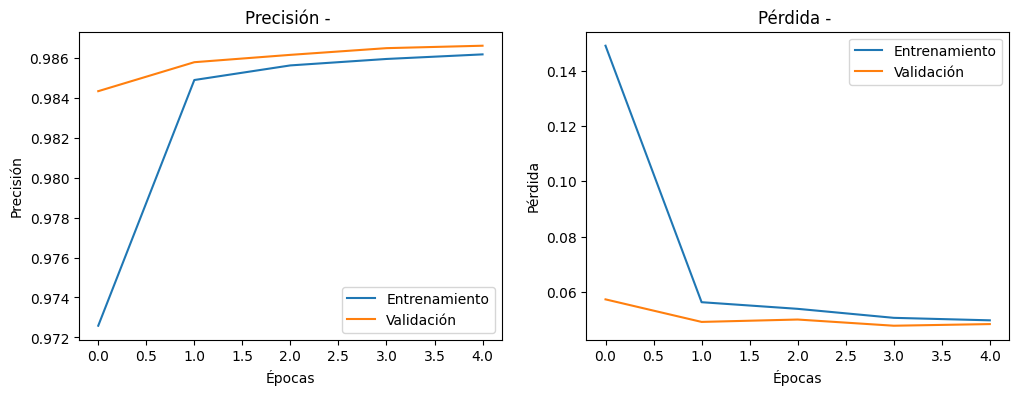

In [15]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=5, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn1.h5")
plot_history(history)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:


# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    "optimizer": ["adam", "rmsprop"],
    "activation": ["relu", "leaky_relu"],
    "learning_rate": [0.001, 0.01],
}

# Crear todas las combinaciones posibles de hiperparámetros
param_combinations = list(product(*param_grid.values()))

# Función para crear y compilar un modelo con una configuración específica de hiperparámetros
def create_model(optimizer, activation, learning_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(2048, 2048, 1)))
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.1) if activation == "leaky_relu" else Activation("relu"))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

best_score = -1
best_params = None


# Prueba cada combinación de hiperparámetros
for params in param_combinations:
    optimizer, activation, learning_rate = params
    model = create_model(optimizer, activation, learning_rate)
    history = model.fit(
        x_train, y_train, epochs=10, batch_size=4, validation_data=(x_val, y_val), verbose=1
    )
    
    # Obtener la precisión de validación en la última época
    val_accuracy = history.history["val_accuracy"][-1]

    print(f"Validación de precisión: {val_accuracy:.4f} con {params}")
    
    # Mostrar gráficos de precisión y pérdida
    plot_history(history)

    # Si esta combinación de hiperparámetros es mejor que la anterior, guárdala
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params


In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    print("GPU disponible:", physical_devices)
else:
    print("No se encontró GPU disponible.")


In [ ]:
import os

os.environ["CUDA_HOME"] = "/usr/local/cuda-11.2"
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CUDA_HOME']}/lib64:{os.environ['LD_LIBRARY_PATH']}"

import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    print("GPU disponible:", physical_devices)
else:
    print("No se encontró GPU disponible.")